### https://www.kaggle.com/vincentman0403/dcgan-on-mnist 


In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import csv
from PIL import Image

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
root = 'DCGAN_results/'

# plotting data structure
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
train_hist['accuracy'] = []
train_hist['Model'] = []


optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def build_generator(pick_model='Deep_BN'):
    if (pick_model == 'Deep_BN') | (pick_model == 'Deeper_D_BN'):
        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()
    
#     elif (pick_model == 'Shallow_BN') | (pick_model == 'Deeper_D_BN'): 

#     elif pick_model == 'Shallow_Drop':
    
#     elif pick_model == 'Drop':
        
        
        
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    
    return Model(noise, img)

## Define a function to build a discriminator

In [4]:
def build_discriminator(pick_model='Deep_BN'):
    if (pick_model == 'Deep_BN') | (pick_model == 'Deeper_D_BN'):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
#     elif (pick_model == 'Shallow_BN') | (pick_model == 'Deeper_G_BN'): 

#     elif pick_model == 'Shallow_Drop':
    
#     elif pick_model == 'Drop':
    
    
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

## Define a function to train GAN

In [5]:
def train(epochs, batch_size=128, save_interval=50, ratio = (1,1), pick_model = 'Deep_BN'): ## ratio G:D
    os.makedirs('images', exist_ok=True)
    
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    
    for epoch in range(epochs):
        # Select a random real images
        epoch_start_time = time.time()
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)
          
        #implement ratio of D  
        if epoch % ratio[0] == 0:
            # Train the discriminator
            D_loss_real = discriminator.train_on_batch(real_imgs, valid)
            D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
            D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)
        #implement ratio of G
        if epoch % ratio[1] == 0:
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid)
            
        # get epoch timing
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
            
        # save data for plotting
        train_hist['D_losses'].append(D_loss[0])
        train_hist['G_losses'].append(g_loss)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)    
        train_hist['accuracy'].append(100 * D_loss[1])
        train_hist['Model'].append(pick_model)
        
        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f] [epoch time: %.2f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss, per_epoch_ptime))
            # Save generated image samples
            save_imgs(epoch, pick_model, ratio)

In [6]:
def save_imgs(epoch, pick_model, ratio):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    os.makedirs(root + 'images/'+  pick_model + '/'+ str(ratio[0]) + '_' + str(ratio[1]) + '/' , exist_ok=True)
    fig.savefig(root + 'images/'+  pick_model + '/'+ str(ratio[0]) + '_' + str(ratio[1]) + '/' + str(epoch) + '.png')
    plt.close()

In [12]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))
    
    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    
    
    if save:
        
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

## Train GAN

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
___________________________

C:\Users\Jack\venv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.942181, acc.: 40.62%] [G loss: 1.353452] [epoch time: 4.63]
200 [D loss: 0.836402, acc.: 45.31%] [G loss: 1.159899] [epoch time: 0.05]
400 [D loss: 0.629150, acc.: 59.38%] [G loss: 0.968065] [epoch time: 0.05]
600 [D loss: 0.855238, acc.: 42.19%] [G loss: 0.945349] [epoch time: 0.05]
800 [D loss: 0.659742, acc.: 57.81%] [G loss: 1.018792] [epoch time: 0.05]
1000 [D loss: 0.757975, acc.: 54.69%] [G loss: 0.953643] [epoch time: 0.05]
1200 [D loss: 0.623840, acc.: 71.88%] [G loss: 1.142944] [epoch time: 0.05]
1400 [D loss: 0.738908, acc.: 48.44%] [G loss: 0.814822] [epoch time: 0.05]
1600 [D loss: 0.708316, acc.: 50.00%] [G loss: 1.029882] [epoch time: 0.05]
1800 [D loss: 0.735274, acc.: 53.12%] [G loss: 0.936292] [epoch time: 0.06]
2000 [D loss: 0.648713, acc.: 60.94%] [G loss: 0.941551] [epoch time: 0.05]
2200 [D loss: 0.618159, acc.: 62.50%] [G loss: 1.080542] [epoch time: 0.05]
2400 [D loss: 0.750311, acc.: 48.44%] [G loss: 0.879783] [epoch time: 0.05]
2600 [D loss: 0.635

PermissionError: [Errno 13] Permission denied: 'DCGAN_results/hist/1_1Deep_BN.png'

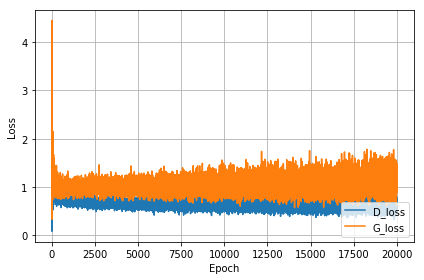

In [8]:
ratio_array = [ (1,1), (1,2), (1,3), (2,3), (3,2), (3,1), (2,1), (10,1), (1,10)]
model_array = ['Deep_BN' ] #'Drop' 'Shallow_BN' 'Shallow_Drop' 'Deeper_G_BN' 'Deeper_D_BN']

for pick_model in model_array:
    #---------------------------COMPILE SELECTED MODELS--------------------------------------#
    # build discriminator
    discriminator = build_discriminator(pick_model=pick_model)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])

    # build generator
    generator = build_generator(pick_model=pick_model)
    z = Input(shape=(100,))
    img = generator(z)

    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    epochs = 20000
    #----------------------------------------LOOP OVER RATIOS--------------------------------#
    for ratio in ratio_array:
        
        #----------------------------------------EXECUTION-----------------------------------#
        start = time.time()

        train(epochs=epochs, batch_size=32, save_interval=epochs/100, ratio=ratio, pick_model=pick_model) ## ratio G:D

        end = time.time()
        
        #--------------------------------------GET--INFO-------------------------------------#
        elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                             int((end - start) % 60))
        train_hist['total_ptime'].append(elapsed_train_time)

        print(elapsed_train_time)
        os.makedirs(root + 'hist/', exist_ok=True)  
        show_train_hist(train_hist, save=True, path=root + 'hist/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.png')
        # save hist data to csv
        os.makedirs(root + 'hist_csv/', exist_ok=True) 
        with open(root+ 'hist_csv/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.csv', 'w') as f:
            for key in train_hist.keys():
                f.write("%s,%s\n"%(key,train_hist[key]))
        
        # save weights
        
        
        # remove old data structure
        del train_hist
        # redefine
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_ptimes'] = []
        train_hist['total_ptime'] = []
        train_hist['accuracy'] = []
        train_hist['Model'] = []
    
    

In [14]:
os.makedirs(root + 'hist/', exist_ok=True)        
show_train_hist(train_hist, save=True, path=root + 'hist/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.png')


In [16]:
os.makedirs(root + 'hist_csv/', exist_ok=True) 
with open(root+ 'hist_csv/' + str(ratio[0]) + '_' + str(ratio[1]) + pick_model +'.csv', 'w') as f:
            for key in train_hist.keys():
                f.write("%s,%s\n"%(key,train_hist[key]))

In [ ]:
os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

## Show generated MNIST images

In [ ]:
Image.open('images/mnist_1000.png')

In [ ]:
Image.open('images/mnist_9000.png')

## Reference
[Keras - DCGAN](https://github.com/eriklindernoren/Keras-GAN#dcgan)